SunPy 라이브러리를 이용하여 e-Callisto 장비에서 측정되는 스펙트럼 데이터를 확인하고 표시하는 방법을 알아보겠습니다.

---

### SunPy 설치

먼저 SunPy를 설치합니다.

    $ pip install sunpy
    
본 예제는 sunpy-0.8.1 환경에서 수행되었습니다.    

---

### 스펙트럼 표출

먼저 SunPy에서 제공하는 [Spectra 예제](http://docs.sunpy.org/en/stable/guide/data_types/spectra.html?highlight=spectra)를 실행시켜봅니다. 샘플 코드는 다음과 같습니다. SunPy를 처음 실행시켰다면, 샘플자료를 다운로드 받습니다. 이 중에서 사용할 파일은 "BIR_20110607_062400_10.fit"입니다.

/Users/tykimos/Projects/Keras/venv/lib/python2.7/site-packages/sunpy/spectra/__init__.py:8: SunpyDeprecationWarning: As of v0.8.0, the `sunpy.spectra` module is deprecated and will be removed in a future version. This module is being moved to sunpyspectra - https://github.com/sunpy/spectra
  warnings.warn( deprecation_message, SunpyDeprecationWarning)


/Users/tykimos/Projects/Keras/venv/lib/python2.7/site-packages/sunpy/spectra/sources/callisto.py:287: SunpyDeprecationWarning: this module is being moved to sunpyspectra - https://github.com/sunpy/spectra
  content, instruments
/Users/tykimos/Projects/Keras/venv/lib/python2.7/site-packages/sunpy/spectra/spectrogram.py:913: SunpyDeprecationWarning: this module is being moved to sunpyspectra - https://github.com/sunpy/spectra
  content, instruments


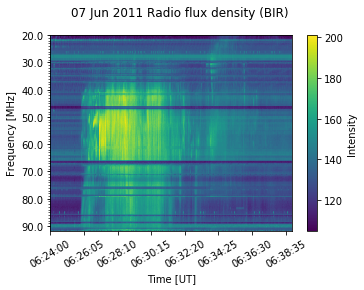

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import sunpy.spectra
import sunpy.data.sample
from sunpy.spectra.sources.callisto import CallistoSpectrogram
image = CallistoSpectrogram.read(sunpy.data.sample.CALLISTO_SPECTRUM)
image.peek()

In [12]:
more = image.extend(minutes=15)
more.peek()

ValueError: Frequency channels do not match.

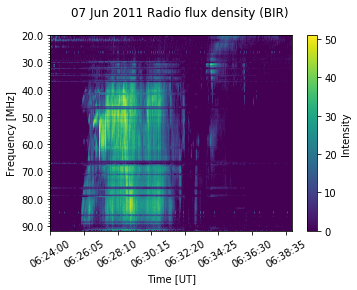

In [7]:
nobg = image.subtract_bg()
nobg.peek(vmin=0)

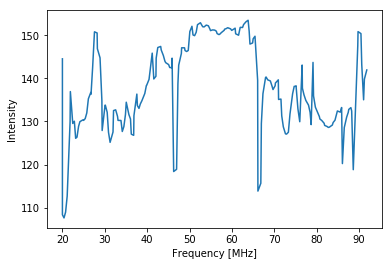

In [8]:
plt.figure()
bg = image.auto_const_bg()
plt.plot(image.freq_axis, bg)
plt.xlabel("Frequency [MHz]")
plt.ylabel("Intensity")
plt.show()

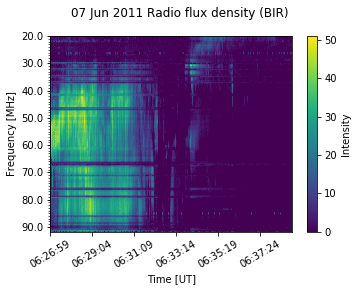

In [9]:
nobg = image.subtract_bg()
interesting = nobg.in_interval("06:27")
interesting.peek(vmin=0)

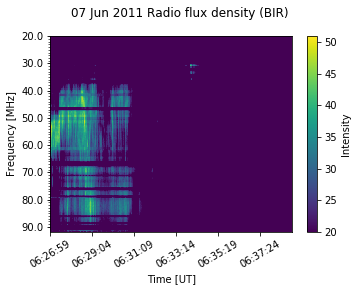

In [10]:
nobg = image.subtract_bg()
interesting = nobg.in_interval("06:27")
interesting.peek(vmin=20)

In [16]:
from sunpy.spectra.sources.callisto import CallistoSpectrogram
d = CallistoSpectrogram.from_range('BIR', '2011-09-22 10:15:00', '2011-09-22 10:45:00')

In [17]:
c1 = CallistoSpectrogram.read('BIR_20110922_101500_01.fit')
c2 = CallistoSpectrogram.read('BIR_20110922_103000_01.fit')
d = CallistoSpectrogram.join_many([c1, c2])

IOError: [Errno 2] No such file or directory: 'BIR_20110922_101500_01.fit'

케라스에서는 다중클래스분류 문제에서 평가기준을 'accuracy'로 지정했을 경우 내부적으로 categorical_accuracy() 함수를 이용하여 정확도가 계산됩니다.

In [27]:
print(sunpy.data.sample.CALLISTO_SPECTRUM)

/Users/tykimos/sunpy/data/sample_data/BIR_20110607_062400_10.fit


In [32]:
import sunpy.spectra.tests.test_callisto as tc

tc.test_read('./test/BIR_20110922_050000_01.fit')

In [ ]:
# -*- coding: utf-8 -*-
# Author: Florian Mayer <florian.mayer@bitsrc.org>

from __future__ import absolute_import

import shutil
from tempfile import mkdtemp
from datetime import datetime

import pytest
import os
import glob
import numpy as np
from numpy.testing import assert_array_almost_equal, assert_allclose
import sunpy.data.test

from sunpy.spectra.sources.callisto import (
    CallistoSpectrogram, query, download, minimal_pairs
)


@pytest.fixture
def CALLISTO_IMAGE():
    testpath = sunpy.data.test.rootdir
    return os.path.join(testpath, 'BIR_20110922_050000_01.fit')


@pytest.fixture
def CALLISTO_IMAGE_GLOB_KEY():
    return 'BIR_*'


@pytest.fixture
def CALLISTO_IMAGE_GLOB_INDEX(CALLISTO_IMAGE, CALLISTO_IMAGE_GLOB_KEY):
    testpath = sunpy.data.test.rootdir
    res = glob.glob(os.path.join(testpath, CALLISTO_IMAGE_GLOB_KEY))
    return res.index(CALLISTO_IMAGE)


def test_read(CALLISTO_IMAGE):
    ca = CallistoSpectrogram.read(CALLISTO_IMAGE)
    assert ca.start == datetime(2011, 9, 22, 5, 0, 0, 454000)
    assert ca.t_init == 18000.0
    assert ca.shape == (200, 3600)
    assert ca.t_delt == 0.25
    # Test linearity of time axis.
    assert np.array_equal(
        ca.time_axis, np.linspace(0, 0.25 * (ca.shape[1] - 1), ca.shape[1])
    )
    assert ca.dtype == np.uint8


@pytest.mark.online
def test_query():
    URL = 'http://soleil.i4ds.ch/solarradio/data/2002-20yy_Callisto/2011/09/22/'

    result = list(query(
        datetime(2011, 9, 22, 5), datetime(2011, 9, 22, 6), set(["BIR"])
    ))
    RESULTS = [
        "BIR_20110922_050000_01.fit.gz",
        "BIR_20110922_051500_01.fit.gz",
        "BIR_20110922_053000_01.fit.gz",
        "BIR_20110922_050000_03.fit.gz",
        "BIR_20110922_051500_03.fit.gz",
        "BIR_20110922_053000_03.fit.gz",
        "BIR_20110922_054500_03.fit.gz",
    ]

    RESULTS.sort()
    # Should be sorted anyway, but better to assume as little as possible.
    result.sort()
    for item in RESULTS:
        assert URL + item in result


@pytest.mark.online
@pytest.mark.xfail
def test_query_number():
    URL = 'http://soleil.i4ds.ch/solarradio/data/2002-20yy_Callisto/2011/09/22/'

    result = list(query(
        datetime(2011, 9, 22, 5), datetime(2011, 9, 22, 6), set([("BIR", 1)])
    ))
    RESULTS = [
        "BIR_20110922_050000_01.fit.gz",
        "BIR_20110922_051500_01.fit.gz",
        "BIR_20110922_053000_01.fit.gz",
    ]

    RESULTS.sort()
    # Should be sorted anyway, but better to assume as little as possible.
    result.sort()

    assert len(result) == len(RESULTS)


@pytest.mark.online
@pytest.mark.xfail
def test_download():
    directory = mkdtemp()
    try:
        result = query(
            datetime(2011, 9, 22, 5), datetime(2011, 9, 22, 6), set([("BIR", 1)])
        )
        RESULTS = [
            "BIR_20110922_050000_01.fit.gz",
            "BIR_20110922_051500_01.fit.gz",
            "BIR_20110922_053000_01.fit.gz",
        ]
        download(result, directory)
        for item in RESULTS:
            assert item in sorted(os.listdir(directory))
    finally:
        shutil.rmtree(directory)


def test_create_file(CALLISTO_IMAGE):
    ca = CallistoSpectrogram.create(CALLISTO_IMAGE)
    assert np.array_equal(ca.data, CallistoSpectrogram.read(CALLISTO_IMAGE).data)


def test_create_file_kw(CALLISTO_IMAGE):
    ca = CallistoSpectrogram.create(filename=CALLISTO_IMAGE)
    assert np.array_equal(ca.data, CallistoSpectrogram.read(CALLISTO_IMAGE).data)


@pytest.mark.online
def test_create_url():
    URL = (
        "http://soleil.i4ds.ch/solarradio/data/2002-20yy_Callisto/2011/09/22/"
        "BIR_20110922_050000_01.fit.gz"
    )
    ca = CallistoSpectrogram.create(URL)
    assert np.array_equal(ca.data, CallistoSpectrogram.read(URL).data)


@pytest.mark.online
def test_create_url_kw():
    URL = (
        "http://soleil.i4ds.ch/solarradio/data/2002-20yy_Callisto/2011/09/22/"
        "BIR_20110922_050000_01.fit.gz"
    )
    ca = CallistoSpectrogram.create(url=URL)
    assert np.array_equal(ca.data, CallistoSpectrogram.read(URL).data)


def test_create_single_glob(CALLISTO_IMAGE, CALLISTO_IMAGE_GLOB_INDEX, CALLISTO_IMAGE_GLOB_KEY):
    PATTERN = os.path.join(os.path.dirname(CALLISTO_IMAGE), CALLISTO_IMAGE_GLOB_KEY)
    ca = CallistoSpectrogram.create(PATTERN)
    assert_allclose(ca[CALLISTO_IMAGE_GLOB_INDEX].data,
                    CallistoSpectrogram.read(CALLISTO_IMAGE).data)


# seems like this does not work anymore and can't figure out what it is for
#def test_create_single_glob_kw(CALLISTO_IMAGE):
#    PATTERN = os.path.join( os.path.dirname(CALLISTO_IMAGE), "BIR_*")
#    ca = CallistoSpectrogram.create(singlepattern=PATTERN)
#    assert np.array_equal(ca[0].data, CallistoSpectrogram.read(CALLISTO_IMAGE).data)

def test_create_glob_kw(CALLISTO_IMAGE, CALLISTO_IMAGE_GLOB_INDEX, CALLISTO_IMAGE_GLOB_KEY):
    PATTERN = os.path.join(
        os.path.dirname(CALLISTO_IMAGE),
        CALLISTO_IMAGE_GLOB_KEY
    )
    ca = CallistoSpectrogram.create(pattern=PATTERN)[CALLISTO_IMAGE_GLOB_INDEX]
    assert_allclose(ca.data, CallistoSpectrogram.read(CALLISTO_IMAGE).data)


def test_create_glob(CALLISTO_IMAGE_GLOB_KEY):
    PATTERN = os.path.join(
        os.path.dirname(sunpy.data.test.__file__),
        CALLISTO_IMAGE_GLOB_KEY
    )
    ca = CallistoSpectrogram.create(PATTERN)
    assert len(ca) == 2


def test_minimum_pairs_commotative():
    A = [0, 1, 2]
    B = [1, 2, 3]
    first = list(minimal_pairs(A, B))
    assert first == [(b, a, d) for a, b, d in minimal_pairs(B, A)]


def test_minimum_pairs_end():
    assert (
        list(minimal_pairs([0, 1, 2, 4], [1, 2, 3, 4])) ==
        [(1, 0, 0), (2, 1, 0), (3, 3, 0)]
    )


def test_minimum_pairs_end_more():
    assert (
        list(minimal_pairs([0, 1, 2, 4, 8], [1, 2, 3, 4])) ==
        [(1, 0, 0), (2, 1, 0), (3, 3, 0)]
    )


def test_minimum_pairs_end_diff():
    assert (
        list(minimal_pairs([0, 1, 2, 8], [1, 2, 3, 4])) ==
        [(1, 0, 0), (2, 1, 0), (3, 3, 4)]
    )


def test_closest():
    assert (
        list(minimal_pairs([50, 60], [0, 10, 20, 30, 40, 51, 52])) ==
        [(0, 5, 1), (1, 6, 8)]
    )


def test_homogenize_factor():
    a = np.float64(np.random.randint(0, 255, 3600))[np.newaxis, :]

    c1 = CallistoSpectrogram(
        a,
        np.arange(3600),
        np.array([1]),
        datetime(2011, 1, 1),
        datetime(2011, 1, 1, 1),
        0,
        1,
        'Time',
        'Frequency',
        'Test',
        None,
        None,
        None,
        False
    )
    b = 2 * a
    c2 = CallistoSpectrogram(
        b,
        np.arange(3600),
        np.array([1]),
        datetime(2011, 1, 1),
        datetime(2011, 1, 1, 1),
        0,
        1,
        'Time',
        'Frequency',
        'Test',
        None,
        None,
        None,
        False
    )

    pairs_indices, factors, constants = c1._homogenize_params(
        c2, 0
    )

    assert pairs_indices == [(0, 0)]
    assert_array_almost_equal(factors, [0.5], 2)
    assert_array_almost_equal(constants, [0], 2)
    assert_array_almost_equal(factors[0] * b + constants[0], a)


def test_homogenize_constant():
    a = np.float64(np.random.randint(0, 255, 3600))[np.newaxis, :]

    c1 = CallistoSpectrogram(
        a,
        np.arange(3600),
        np.array([1]),
        datetime(2011, 1, 1),
        datetime(2011, 1, 1, 1),
        0,
        1,
        'Time',
        'Frequency',
        'Test',
        None,
        None,
        None,
        False
    )
    b = a + 10
    c2 = CallistoSpectrogram(
        b,
        np.arange(3600),
        np.array([1]),
        datetime(2011, 1, 1),
        datetime(2011, 1, 1, 1),
        0,
        1,
        'Time',
        'Frequency',
        'Test',
        None,
        None,
        None,
        False
    )

    pairs_indices, factors, constants = c1._homogenize_params(
        c2, 0
    )

    assert pairs_indices == [(0, 0)]
    assert_array_almost_equal(factors, [1], 2)
    assert_array_almost_equal(constants, [-10], 2)
    assert_array_almost_equal(factors[0] * b + constants[0], a)


def test_homogenize_both():
    a = np.float64(np.random.randint(0, 255, 3600))[np.newaxis, :]

    c1 = CallistoSpectrogram(
        a,
        np.arange(3600),
        np.array([1]),
        datetime(2011, 1, 1),
        datetime(2011, 1, 1, 1),
        0,
        1,
        'Time',
        'Frequency',
        'Test',
        None,
        None,
        None,
        False
    )
    b = 2 * a + 1
    c2 = CallistoSpectrogram(
        b,
        np.arange(3600),
        np.array([1]),
        datetime(2011, 1, 1),
        datetime(2011, 1, 1, 1),
        0,
        1,
        'Time',
        'Frequency',
        'Test',
        None,
        None,
        None,
        False
    )

    pairs_indices, factors, constants = c1._homogenize_params(
        c2, 0
    )

    assert pairs_indices == [(0, 0)]
    assert_array_almost_equal(factors, [0.5], 2)
    assert_array_almost_equal(constants, [-0.5], 2)
    assert_array_almost_equal(factors[0] * b + constants[0], a)


def test_homogenize_rightfq():
    a = np.float64(np.random.randint(0, 255, 3600))[np.newaxis, :]

    c1 = CallistoSpectrogram(
        a,
        np.arange(3600),
        np.array([1]),
        datetime(2011, 1, 1),
        datetime(2011, 1, 1, 1),
        0,
        1,
        'Time',
        'Frequency',
        'Test',
        None,
        None,
        None,
        False
    )
    b = 2 * a + 1
    c2 = CallistoSpectrogram(
        np.concatenate([
            np.arange(3600)[np.newaxis, :], b,
            np.arange(3600)[np.newaxis, :]
            ], 0),
        np.arange(3600),
        np.array([0, 1, 2]),
        datetime(2011, 1, 1),
        datetime(2011, 1, 1, 1),
        0,
        1,
        'Time',
        'Frequency',
        'Test',
        None,
        None,
        None,
        False
    )
    pairs_indices, factors, constants = c1._homogenize_params(
        c2, 0
    )
    assert pairs_indices == [(0, 1)]
    assert_array_almost_equal(factors, [0.5], 2)
    assert_array_almost_equal(constants, [-0.5], 2)
    assert_array_almost_equal(factors[0] * b + constants[0], a)


@pytest.mark.online
def test_extend(CALLISTO_IMAGE):
    im = CallistoSpectrogram.create(CALLISTO_IMAGE)
    im2 = im.extend()
    # Not too stable test, but works.
    assert im2.data.shape == (200, 7200)


In [36]:
tc.test_extend(tc.CALLISTO_IMAGE())

이런 평가 기준을 정의하는 함수는 두 개의 인자를 받습니다.
* y_true: 실제 값, 티아노 및 텐스플로우의 텐서(tensor)
* y_pred: 예측 값, 티아노 및 텐스플로우의 텐서(tensor)

함수 내부는 어떻게 평가를 할 것인가를 정의합니다. 이 함수는 매 배치때마다 호출되며 입력되는 데이터들에 대해 평가를 수행한 후 그 결과의 평균을 하나의 텐서로 반환합니다.

---

### 사용자 정의 메트릭

케라스에서 제공하는 함수형태와 비슷하게 사용자 정의 메트릭을 만들 수 있습니다. 아래 코드는 특정 클래스에 대한 정밀도를 평가하는 함수입니다. 여러 개의 클래스를 하나의 함수로 사용할 수 있도록 'interesting_class_id' 인자를 사용하였습니다.

In [ ]:
def single_class_precision(interesting_class_id):
    def prec(y_true, y_pred):
        class_id_true = K.argmax(y_true, axis=-1)
        class_id_pred = K.argmax(y_pred, axis=-1)
        precision_mask = K.cast(K.equal(class_id_pred, interesting_class_id), 'int32')
        class_prec_tensor = K.cast(K.equal(class_id_true, class_id_pred), 'int32') * precision_mask
        class_prec = K.cast(K.sum(class_prec_tensor), 'float32') / K.cast(K.maximum(K.sum(precision_mask), 1), 'float32')
        return class_prec
    return prec

분류 문제에서 클래스별로 확인할 때는 정밀도와 재현율을 파악하는 것이 도움이 됩니다. 정밀도와 재현율의 개념에 대해서는 ['평가 이야기'](https://tykimos.github.io/2017/05/22/Evaluation_Talk/)을 참고하시기 바랍니다. 아래 코드는 특정 클래스에 대한 재현율을 평가하는 함수입니다.

In [ ]:
def single_class_recall(interesting_class_id):
    def recall(y_true, y_pred):
        class_id_true = K.argmax(y_true, axis=-1)
        class_id_pred = K.argmax(y_pred, axis=-1)
        recall_mask = K.cast(K.equal(class_id_true, interesting_class_id), 'int32')
        class_recall_tensor = K.cast(K.equal(class_id_true, class_id_pred), 'int32') * recall_mask
        class_recall = K.cast(K.sum(class_recall_tensor), 'float32') / K.cast(K.maximum(K.sum(recall_mask), 1), 'float32')
        return class_recall
    return recall

---

### 사용자 정의 메트릭 사용하기

사용자 정의 메트릭을 사용할 때는 compile() 함수의 metrics 인자에 함수명을 삽입합니다. 'interesting_class_id' 인자를 사용하였으므로, 클래스 인덱스를 넘기도록 합니다. 본 예제에서는 mnist을 사용하기 때문에 0~9까지로 살펴보도록 하겠습니다.

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='sgd', 
              metrics=['accuracy',
                       single_class_precision(0), single_class_recall(0),
                       single_class_precision(1), single_class_recall(1),
                       single_class_precision(2), single_class_recall(2),
                       single_class_precision(3), single_class_recall(3),
                       single_class_precision(4), single_class_recall(4),
                       single_class_precision(5), single_class_recall(5),
                       single_class_precision(6), single_class_recall(6),
                       single_class_precision(7), single_class_recall(7),
                       single_class_precision(8), single_class_recall(8),
                       single_class_precision(9), single_class_recall(9)])

---

### 학습과정 살펴보기

fit() 함수는 히스토리 객체를 반환하는 데, 이 객체에는 매 에포크마다 prec_1, prec_2, prec_3... prec_10과 recall_1, recall_2, recall_3... recall_10의 값을 가지고 있습니다.

In [ ]:
hist = model.fit(x_train, y_train, epochs=5, batch_size=32)

메트릭을 여러개 지정할 경우 아래와 같이 fit() 함수 실행 시 로그에도 여러 개의 메트릭이 표시됩니다. 동시에 여러 수치가 올라가는 것을 보고있노라면 마치 참새가 재잘거리는 소리가 들리는 것 같군요.

![img](https://tykimos.github.io/warehouse/2017-9-24-Custom_Metric_log.gif)

이 값을 시각화하는 코드는 다음과 같습니다.

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(hist.history['prec_1'], label='precision 1')
plt.plot(hist.history['prec_2'], label='precision 2')
plt.plot(hist.history['prec_3'], label='precision 3')
plt.plot(hist.history['prec_4'], label='precision 4')
plt.plot(hist.history['prec_5'], label='precision 5')
plt.plot(hist.history['prec_6'], label='precision 6')
plt.plot(hist.history['prec_7'], label='precision 7')
plt.plot(hist.history['prec_8'], label='precision 8')
plt.plot(hist.history['prec_9'], label='precision 9')
plt.plot(hist.history['prec_10'], label='precision 10')
plt.xlabel('epoch')
plt.ylabel('precision')
plt.legend(loc='lower right')
plt.show()

![img](https://tykimos.github.io/warehouse/2017-9-24-Custom_Metric_output_23_1.png)

In [ ]:
plt.plot(hist.history['recall_1'], label='recall 1')
plt.plot(hist.history['recall_2'], label='recall 2')
plt.plot(hist.history['recall_3'], label='recall 3')
plt.plot(hist.history['recall_4'], label='recall 4')
plt.plot(hist.history['recall_5'], label='recall 5')
plt.plot(hist.history['recall_6'], label='recall 6')
plt.plot(hist.history['recall_7'], label='recall 7')
plt.plot(hist.history['recall_8'], label='recall 8')
plt.plot(hist.history['recall_9'], label='recall 9')
plt.plot(hist.history['recall_10'], label='recall 10')
plt.xlabel('epoch')
plt.ylabel('recall')
plt.legend(loc='lower right')
plt.show()

![img](https://tykimos.github.io/warehouse/2017-9-24-Custom_Metric_output_23_2.png)

---

### 메트릭을 이용한 평가결과 살펴보기

evaluate() 함수는 손실값 및 메트릭 값을 반환하는 데, 여러 메트릭을 정의 및 등록하였으므로, 여러 개의 메트릭 값을 얻을 수 있습니다.

In [ ]:
loss_and_metrics = model.evaluate(x_test, y_test, batch_size=32)

아래는 평가를 통해 얻은 메트릭 값을 시각화하는 코드입니다. 클래스별로 정밀도와 재현율을 막대그래프로 표시해봤습니다.

In [ ]:
import numpy as np

metrics = np.array(loss_and_metrics[2:])
idx = np.linspace(0, 19, 20) 
precision = metrics[(idx % 2) == 0]
recall = metrics[((idx+1) % 2) == 0]

import matplotlib.pyplot as plt

N = 10
ind = np.arange(N)
width = 0.35

fig, ax = plt.subplots()
prec_bar = ax.bar(ind, precision, width, color='r')
recall_bar = ax.bar(ind + width, recall, width, color='y')

ax.set_ylabel('Scores')
ax.set_title('Precision and Recall')
ax.set_xticks(ind + width / 2)
ax.set_xticklabels(('C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10'))

ax.legend((prec_bar[0], recall_bar[0]), ('Precision', 'Recall'))

plt.show()

![img](https://tykimos.github.io/warehouse/2017-9-24-Custom_Metric_output_23_4.png)

---

### 전체 소스코드

전체 소스코드는 다음과 같습니다. 기본적인 mnist 예제에서 사용자 정의 메트릭 정의 및 등록과 시각화 하는 부분이 추가되었습니다.

Epoch 1/5
60000/60000 [==============================] - 7s - loss: 0.6639 - acc: 0.8324 - prec_1: 0.8705 - recall_1: 0.9026 - prec_2: 0.8434 - recall_2: 0.8951 - prec_3: 0.8080 - recall_3: 0.7866 - prec_4: 0.7888 - recall_4: 0.7829 - prec_5: 0.7889 - recall_5: 0.8232 - prec_6: 0.7472 - recall_6: 0.6403 - prec_7: 0.8516 - recall_7: 0.8736 - prec_8: 0.8397 - recall_8: 0.8406 - prec_9: 0.7332 - recall_9: 0.7501 - prec_10: 0.7570 - recall_10: 0.7301     
Epoch 2/5
60000/60000 [==============================] - 7s - loss: 0.3468 - acc: 0.9031 - prec_1: 0.9029 - recall_1: 0.9249 - prec_2: 0.9138 - recall_2: 0.9442 - prec_3: 0.8696 - recall_3: 0.8409 - prec_4: 0.8610 - recall_4: 0.8441 - prec_5: 0.8648 - recall_5: 0.8857 - prec_6: 0.8236 - recall_6: 0.8028 - prec_7: 0.8917 - recall_7: 0.9036 - prec_8: 0.8961 - recall_8: 0.8888 - prec_9: 0.8348 - recall_9: 0.8321 - prec_10: 0.8462 - recall_10: 0.8455     
Epoch 3/5
60000/60000 [==============================] - 7s - loss: 0.3002 - acc: 0.9155

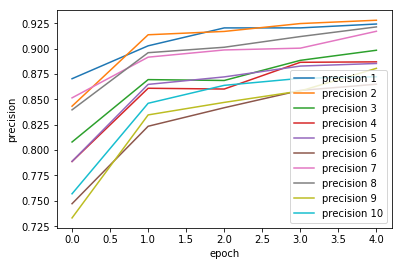

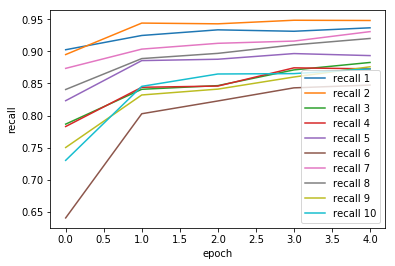

 9664/10000 [===========================>..] - ETA: 0s## evaluation loss and_metrics ##
[0.23389623485803604, 0.93569999999999998, 0.93501714344024656, 0.96290285758972172, 0.95712000045776369, 0.95975619077682495, 0.91664761981964116, 0.90009523944854741, 0.90259047775268553, 0.92727619199752809, 0.886011429977417, 0.91370666770935061, 0.87623619136810305, 0.85451682758331304, 0.92037333421707157, 0.92180571537017819, 0.9204723814964294, 0.90364190587997439, 0.90296889028549199, 0.89279238224029545, 0.88955913543701171, 0.87660952548980708]


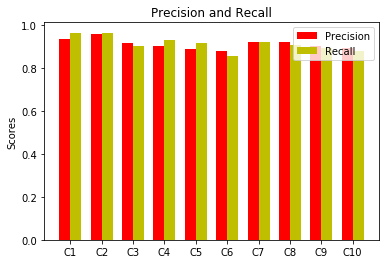

In [3]:
# 0. 사용할 패키지 불러오기
from keras.utils import np_utils
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Activation

from keras import backend as K

# 특정 클래스에 대한 정밀도
def single_class_precision(interesting_class_id):
    def prec(y_true, y_pred):
        class_id_true = K.argmax(y_true, axis=-1)
        class_id_pred = K.argmax(y_pred, axis=-1)
        precision_mask = K.cast(K.equal(class_id_pred, interesting_class_id), 'int32')
        class_prec_tensor = K.cast(K.equal(class_id_true, class_id_pred), 'int32') * precision_mask
        class_prec = K.cast(K.sum(class_prec_tensor), 'float32') / K.cast(K.maximum(K.sum(precision_mask), 1), 'float32')
        return class_prec
    return prec

# 특정 클래스에 대한 재현율
def single_class_recall(interesting_class_id):
    def recall(y_true, y_pred):
        class_id_true = K.argmax(y_true, axis=-1)
        class_id_pred = K.argmax(y_pred, axis=-1)
        recall_mask = K.cast(K.equal(class_id_true, interesting_class_id), 'int32')
        class_recall_tensor = K.cast(K.equal(class_id_true, class_id_pred), 'int32') * recall_mask
        class_recall = K.cast(K.sum(class_recall_tensor), 'float32') / K.cast(K.maximum(K.sum(recall_mask), 1), 'float32')
        return class_recall
    return recall

# 1. 데이터셋 생성하기
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.reshape(60000, 784).astype('float32') / 255.0
x_test = x_test.reshape(10000, 784).astype('float32') / 255.0
y_train = np_utils.to_categorical(y_train)
y_test = np_utils.to_categorical(y_test)

# 2. 모델 구성하기
model = Sequential()
model.add(Dense(units=64, input_dim=28*28, activation='relu'))
model.add(Dense(units=10, activation='softmax'))

# 3. 모델 학습과정 설정하기
model.compile(loss='categorical_crossentropy', optimizer='sgd', 
              metrics=['accuracy',
                       single_class_precision(0), single_class_recall(0),
                       single_class_precision(1), single_class_recall(1),
                       single_class_precision(2), single_class_recall(2),
                       single_class_precision(3), single_class_recall(3),
                       single_class_precision(4), single_class_recall(4),
                       single_class_precision(5), single_class_recall(5),
                       single_class_precision(6), single_class_recall(6),
                       single_class_precision(7), single_class_recall(7),
                       single_class_precision(8), single_class_recall(8),
                       single_class_precision(9), single_class_recall(9)])

# 4. 모델 학습시키기
hist = model.fit(x_train, y_train, epochs=5, batch_size=32)

# 5. 학습과정 살펴보기
%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(hist.history['prec_1'], label='precision 1')
plt.plot(hist.history['prec_2'], label='precision 2')
plt.plot(hist.history['prec_3'], label='precision 3')
plt.plot(hist.history['prec_4'], label='precision 4')
plt.plot(hist.history['prec_5'], label='precision 5')
plt.plot(hist.history['prec_6'], label='precision 6')
plt.plot(hist.history['prec_7'], label='precision 7')
plt.plot(hist.history['prec_8'], label='precision 8')
plt.plot(hist.history['prec_9'], label='precision 9')
plt.plot(hist.history['prec_10'], label='precision 10')
plt.xlabel('epoch')
plt.ylabel('precision')
plt.legend(loc='lower right')
plt.show()

plt.plot(hist.history['recall_1'], label='recall 1')
plt.plot(hist.history['recall_2'], label='recall 2')
plt.plot(hist.history['recall_3'], label='recall 3')
plt.plot(hist.history['recall_4'], label='recall 4')
plt.plot(hist.history['recall_5'], label='recall 5')
plt.plot(hist.history['recall_6'], label='recall 6')
plt.plot(hist.history['recall_7'], label='recall 7')
plt.plot(hist.history['recall_8'], label='recall 8')
plt.plot(hist.history['recall_9'], label='recall 9')
plt.plot(hist.history['recall_10'], label='recall 10')
plt.xlabel('epoch')
plt.ylabel('recall')
plt.legend(loc='lower right')
plt.show()

# 6. 모델 평가하기
loss_and_metrics = model.evaluate(x_test, y_test, batch_size=32)
print('## evaluation loss and_metrics ##')
print(loss_and_metrics)

import numpy as np

metrics = np.array(loss_and_metrics[2:])
idx = np.linspace(0, 19, 20) 
precision = metrics[(idx % 2) == 0]
recall = metrics[((idx+1) % 2) == 0]

import matplotlib.pyplot as plt

N = 10
ind = np.arange(N)
width = 0.35

fig, ax = plt.subplots()
prec_bar = ax.bar(ind, precision, width, color='r')
recall_bar = ax.bar(ind + width, recall, width, color='y')

ax.set_ylabel('Scores')
ax.set_title('Precision and Recall')
ax.set_xticks(ind + width / 2)
ax.set_xticklabels(('C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10'))

ax.legend((prec_bar[0], recall_bar[0]), ('Precision', 'Recall'))

plt.show()

---

### 요약

다중클래스분류 문제에서 클래스별로 정밀도 및 재현율을 알아보기 위해 사용자 정의 메트릭을 정의하고 등록하는 법을 알아보왔습니다. 그리고 학습 과정 및 평가 시에 산출되는 메트릭 값을 차트를 통해 시각화하는 방법에 대해서도 알아봤습니다. 이 방법들을 통해 'accuracy' 값만 보던 것을 벗어나 다양한 평가 기준으로 모델의 학습과정을 살펴보시기 바랍니다.

---

### 같이 보기

* [강좌 목차](https://tykimos.github.io/lecture/)
* [평가 이야기](https://tykimos.github.io/2017/05/22/Evaluation_Talk/)